# Assignment 11 - Viraj Noorithaya


## Final Test Accuracy - X%


## Script Parameters


In [1]:
# Where are you running this? Can be either 'local' or 'colab'
model_run_location = "colab"

# # Do you want to install the required packages?
# install_required_packages = False
install_required_packages = False if model_run_location == "local" else True

# git repository url
repo_name = "era-v1"
git_repo_url = "https://github.com/nviraj/era-v1.git"

# Is the model being developed or is it in production?
# Can be development or production
code_mode = "development"

# WHich branch are you working on?
branch_name = "week-11" if code_mode == "development" else "main"
folder_name = "Session 11/Submission"

## Library Installation (Optional)


In [2]:
# # Install any required libraries not present in your working environment

if install_required_packages:
    # # Needed locally and in colab
    # !pip install torchsummary
    # !conda install -c frgfm torchscan

    import sys
    # !{sys.executable} -m pip install torchsummary
    !{sys.executable} -m pip install torch-lr-finder
    !{sys.executable} -m pip install torchinfo
    # https://github.com/jacobgil/pytorch-grad-cam
    !{sys.executable} -m pip install grad-cam

    # if model_run_location == 'colab':
    #     !{sys.executable} -m pip install albumentations

    # # Needed locally
    # !conda install -c conda-forge tqdm
    # !conda install -c anaconda ipywidgets

    if model_run_location == 'local':
        %conda install --yes --prefix {sys.prefix} -c conda-forge tqdm
        %conda install --yes --prefix {sys.prefix} -c anaconda ipywidgets
        %conda install --yes --prefix {sys.prefix} -c conda-forge imgaug
        %conda install --yes --prefix {sys.prefix} -c conda-forge albumentations


## Code Procurement


In [3]:
import sys
import os 

# Current working directory
print(f"CWD: {os.getcwd()}")

# Mount google drive if running on colab
if model_run_location == 'colab':
    # from google.colab import drive
    # drive.mount('/content/drive')
    # %cd /content/drive/MyDrive/WorkSpace/era-v1/Session 10/Submission

    # Delete the folder if it exists
    # Avoids fatal: destination path already exists and is not an empty directory.
    # Get code from github
    !rm -rf {repo_name} && git clone {git_repo_url}

    # Switch to repo folder, Needed to switch branch
    # Switch branch and change to the correct directory
    !cd "{repo_name}" && git checkout {branch_name} && cd "{folder_name}"

    # Make custom modules available
    print(f"Appending folder to path in order to detect modules: {folder_name}")
    sys.path.append(f"era-v1/{folder_name}")

CWD: d:\Root\Personal\WorkSpace\era-v1\Session 11\Submission


## Import Libraries


In [4]:
# Import necessary modules (external libs)
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR

In [5]:
# Import user defined modules
from models.resnet import ResNet18 as Net
from models.resnet import detailed_model_summary
from modules.dataset import CIFAR_CLASSES, get_cifar_dataloaders
from modules.trainer import find_optimal_lr, train_and_test_model
from modules.utils import (get_device, get_num_workers, pretty_print_metrics,
                           save_model)
from modules.visualize import (plot_gradcam_images, plot_misclassified_images,
                               plot_sample_training_images,
                               plot_train_test_metrics)

d:\Apps\Anaconda3\envs\era-v1\Lib\site-packages\torch_lr_finder\lr_finder.py:5: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


## Script Parameters


In [6]:
# Constants naming convention: All caps separated by underscore
# https://realpython.com/python-constants/

# Where do we store the data?
data_path = "../../data"

# Specify the number of epochs
NUM_EPOCHS = 20

# Set the batch size
BATCH_SIZE = 512

# What is the start LR and weight decay you'd prefer?
PREFERRED_START_LR = 3e-2
PREFERRED_WEIGHT_DECAY = 0

# Set seed value for reproducibility
SEED = 26

# Expected accuracy
TARGET_ACCURACY = 85.0

## Get Device and Workers


In [7]:
# Functionality to check cuda support and create device is now moved to utils.py
device_support, device = get_device()

# How many workers do you need?
num_workers = get_num_workers(model_run_location)

print(
    f"Run location: {model_run_location}, \n",
    f"Device: {device_support}, \n",
    f"Number of workers: {num_workers}, \n",
    f"Batch size: {BATCH_SIZE} \n",
    f"Seed: {SEED} \n",
    f"Data path: {data_path}",
)

Run location: local, 
 Device: {device_support}, 
 Number of workers: {num_workers}, 
 Batch size: {BATCH_SIZE} 
 Seed: {SEED} 
 Data path: {data_path}


### Reproducibility settings


In [8]:
# For reproducibility
# https://pytorch.org/docs/stable/notes/randomness.html
# https://github.com/pytorch/pytorch/issues/7068
import random
import numpy as np

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

if device_support == "cuda":
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

## Dataloaders


In [9]:
# Get the train and test loader
# Transformations for the train and test data is present in dataset.py
train_loader, test_loader = get_cifar_dataloaders(
    data_path=data_path, batch_size=BATCH_SIZE, num_workers=num_workers, seed=SEED
)

# Get class mapping for the dataset
classes = CIFAR_CLASSES
print(f"Class Labels: {classes}")

Train and test data path: ../../data
Splitting the dataset into train and test


Files already downloaded and verified
Files already downloaded and verified

Mean: [0.4914009  0.48215896 0.4465308 ]
Std: [0.24703279 0.24348423 0.26158753]

Transformations applied on the dataset

Dataloader arguments: {'shuffle': True, 'batch_size': 512, 'num_workers': 0, 'pin_memory': True, 'worker_init_fn': <function get_cifar_dataloaders.<locals>._init_fn at 0x0000013D201F6840>}

Creating train and test dataloaders

Class Labels: ('Plane', 'Car', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck')


## Sample Training Images


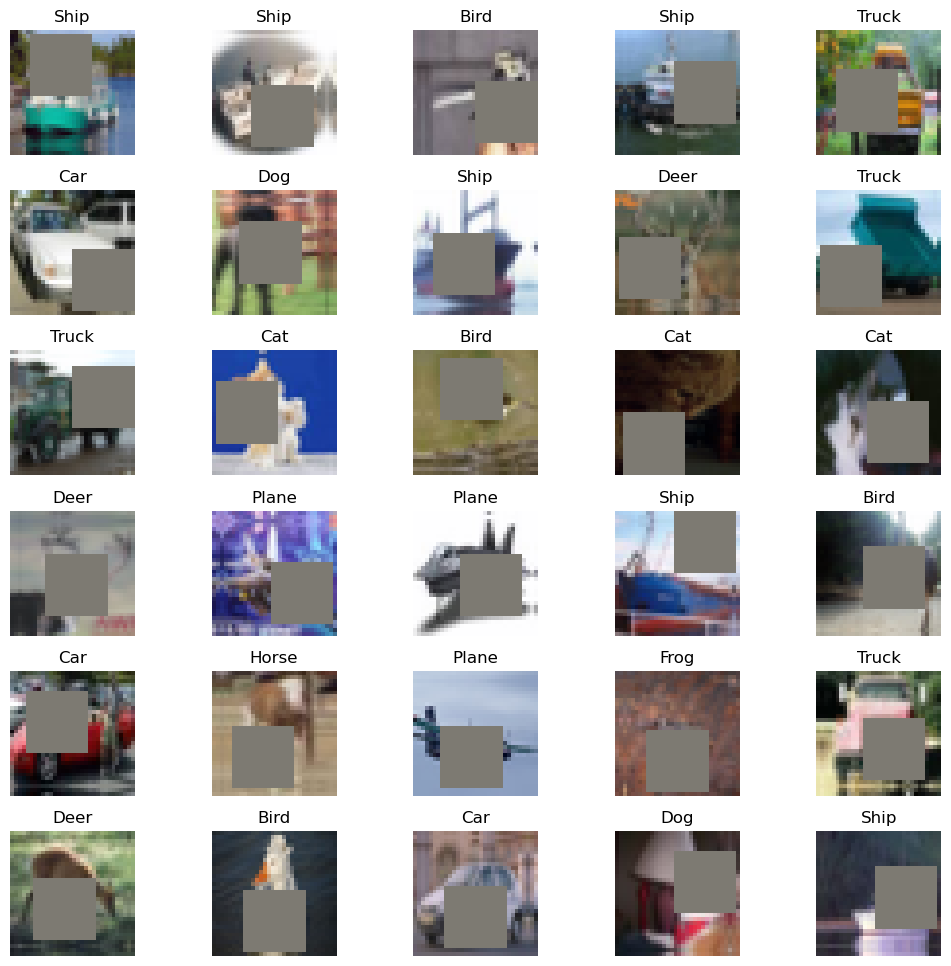

In [10]:
# Get a batch of training data from train_loader
batch_data, batch_label = next(iter(train_loader))

# Plot 30 sample images from the training data along with their labels
# plot_sample_training_images() imported from utils.py
fig, axs = plot_sample_training_images(
    batch_data, batch_label, class_label=classes, num_images=30
)
plt.show()

## Model Summary


In [11]:
# Model class is imported from model.py

# Send the model to device
model = Net().to(device)

# enable printing shape
model.print_shape = True

# # Print the model summary by specifying the input size
# summary(model, input_size=(3, 32, 32))
detailed_model_summary(model, input_size=(3, 32, 32), device=device)

# disable printing shape for cleaner test train output
model.print_shape = False

PrepLayer 
	 torch.Size([1, 64, 32, 32]) 

Layer 1 
	 torch.Size([1, 64, 32, 32]) 

Layer 2 
	 torch.Size([1, 128, 16, 16]) 

Layer 3 
	 torch.Size([1, 256, 8, 8]) 

Layer 4 
	 torch.Size([1, 512, 4, 4]) 

Post GAP 
	 torch.Size([1, 512, 1, 1]) 

Reshape before FC 
	 torch.Size([1, 512]) 

After FC 
	 torch.Size([1, 10]) 

Layer (type:depth-idx)                   Input Shape      Kernel Shape     Output Shape     Param #          Trainable
ResNet                                   [1, 3, 32, 32]   --               [1, 10]          --               True
├─Conv2d: 1-1                            [1, 3, 32, 32]   [3, 3]           [1, 64, 32, 32]  1,728            True
├─BatchNorm2d: 1-2                       [1, 64, 32, 32]  --               [1, 64, 32, 32]  128              True
├─Sequential: 1-3                        [1, 64, 32, 32]  --               [1, 64, 32, 32]  --               True
│    └─BasicBlock: 2-1                   [1, 64, 32, 32]  --               [1, 64, 32, 32]  --      

## Train and Test


### Optimizer and Loss Function


In [12]:
# Create optimizer and scheduler
# Use ADAM
# https://pytorch.org/docs/stable/generated/torch.optim.Adam.html
optimizer = optim.Adam(
    model.parameters(), lr=PREFERRED_START_LR, weight_decay=PREFERRED_WEIGHT_DECAY
)

# Define criteria function
# https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html
criterion = torch.nn.CrossEntropyLoss()

### Find Learning Rate


  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.80E-01


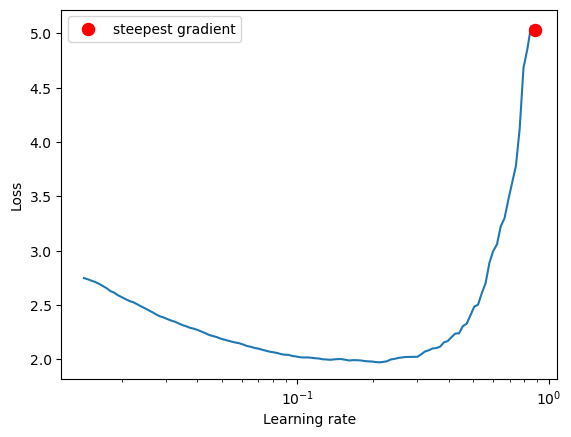

In [13]:
# Find optimal LR to start with
suggested_lr = find_optimal_lr(
    model, optimizer, criterion, train_loader, start_lr=PREFERRED_START_LR
)

### Scheduler


In [14]:
# suggested_lr = 0.2
print(f"Suggested Max LR: {suggested_lr}")

# Learning rate scheduler based on OneCycleLR
# https://pytorch.org/docs/stable/generated/torch.optim.lr_scheduler.OneCycleLR.html
scheduler = OneCycleLR(
    optimizer,
    max_lr=suggested_lr,
    steps_per_epoch=len(train_loader),
    epochs=NUM_EPOCHS,
    pct_start=5 / NUM_EPOCHS,
    div_factor=5,
    three_phase=False,
    anneal_strategy="linear",
    final_div_factor=20,
    verbose=False,
)

Suggested Max LR: 0.8804883581643465


### Train and test model


In [15]:
# Create a dictionary of lists for misclassified images, generated predictions and ground truth
misclassified_image_data = {"images": [], "ground_truths": [], "predicted_vals": []}

# Run the model for NUM_EPOCHS
results = train_and_test_model(
    batch_size=BATCH_SIZE,
    num_epochs=NUM_EPOCHS,
    model=model,
    device=device,
    train_loader=train_loader,
    test_loader=test_loader,
    optimizer=optimizer,
    criterion=criterion,
    scheduler=scheduler,
    misclassified_image_data=misclassified_image_data,
)



Batch size: 512, Total epochs: 7


Epoch 1


Training: Batch = 97, : 100%|██████████| 98/98 [00:43<00:00,  2.25it/s]


Training:	Average Loss: 3.55866,  Accuracy: 12.96%)
Testing:	Average Loss: 0.03410,  Accuracy: 9.97%)


Epoch 2


Training: Batch = 97, : 100%|██████████| 98/98 [00:43<00:00,  2.27it/s]


Training:	Average Loss: 2.44853,  Accuracy: 20.53%)
Testing:	Average Loss: 0.00445,  Accuracy: 16.76%)


Epoch 3


Training: Batch = 97, : 100%|██████████| 98/98 [00:43<00:00,  2.27it/s]


Training:	Average Loss: 1.92611,  Accuracy: 28.29%)
Testing:	Average Loss: 0.00493,  Accuracy: 22.51%)


Epoch 4


Training: Batch = 97, : 100%|██████████| 98/98 [00:42<00:00,  2.30it/s]


Training:	Average Loss: 1.73993,  Accuracy: 34.72%)
Testing:	Average Loss: 0.00482,  Accuracy: 25.47%)


Epoch 5


Training: Batch = 97, : 100%|██████████| 98/98 [00:43<00:00,  2.24it/s]


Training:	Average Loss: 1.61002,  Accuracy: 39.83%)
Testing:	Average Loss: 0.00441,  Accuracy: 30.92%)


Epoch 6


Training: Batch = 97, : 100%|██████████| 98/98 [00:49<00:00,  1.97it/s]


Training:	Average Loss: 1.56920,  Accuracy: 41.53%)
Testing:	Average Loss: 0.00368,  Accuracy: 34.71%)


Epoch 7


Training: Batch = 97, : 100%|██████████| 98/98 [00:43<00:00,  2.23it/s]


Training:	Average Loss: 1.52728,  Accuracy: 43.07%)
Testing:	Average Loss: 0.00471,  Accuracy: 34.20%)




In [16]:
# Pretty print train and test accuracy and loss values for each epoch
pretty_print_metrics(num_epochs=NUM_EPOCHS, results=results)

Epoch: 01, Train Loss: 3.5587, Test Loss: 0.0341, Train Accuracy: 12.9580, Test Accuracy: 9.9700
Epoch: 02, Train Loss: 2.4485, Test Loss: 0.0045, Train Accuracy: 20.5260, Test Accuracy: 16.7600
Epoch: 03, Train Loss: 1.9261, Test Loss: 0.0049, Train Accuracy: 28.2920, Test Accuracy: 22.5100
Epoch: 04, Train Loss: 1.7399, Test Loss: 0.0048, Train Accuracy: 34.7240, Test Accuracy: 25.4700
Epoch: 05, Train Loss: 1.6100, Test Loss: 0.0044, Train Accuracy: 39.8280, Test Accuracy: 30.9200
Epoch: 06, Train Loss: 1.5692, Test Loss: 0.0037, Train Accuracy: 41.5260, Test Accuracy: 34.7100
Epoch: 07, Train Loss: 1.5273, Test Loss: 0.0047, Train Accuracy: 43.0660, Test Accuracy: 34.2000


## Metrics


Expected accuracy: 85.0%
Plotting accuracy and loss graphs.


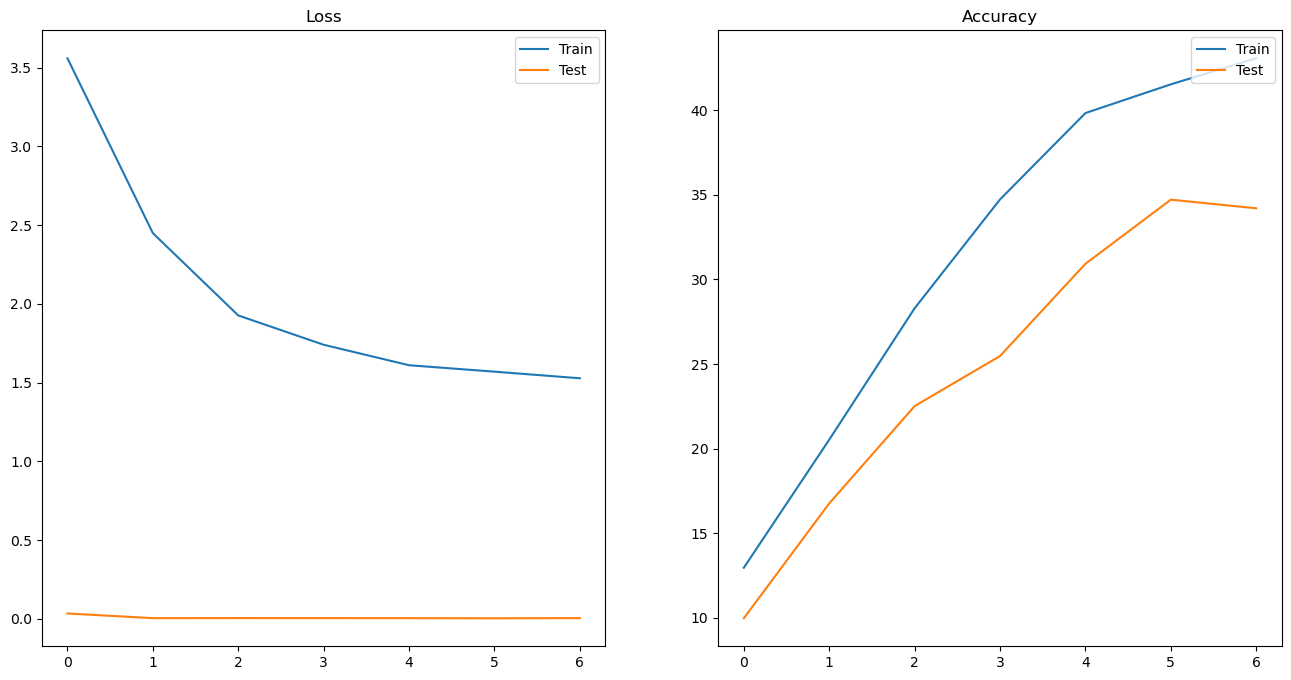

In [17]:
# Print expected accuracy for easier reference
print(f"Expected accuracy: {TARGET_ACCURACY}%")

# Plot the accuracy and loss graphs using data and plot_train_test_metrics() from model.py
print("Plotting accuracy and loss graphs.")
fig, axs = plot_train_test_metrics(results)
plt.show()
# plt.savefig("Loss and Accuracy Metrics.png")

## Save model


In [18]:
# Save model
print("Saving the model as the training is complete!")
save_model(
    epoch=NUM_EPOCHS,
    model=model,
    optimizer=optimizer,
    scheduler=scheduler,
    batch_size=BATCH_SIZE,
    criterion=criterion,
    file_name="model_last_epoch.pth",
)

Saving the model as the training is complete!


## Show Misclassified images


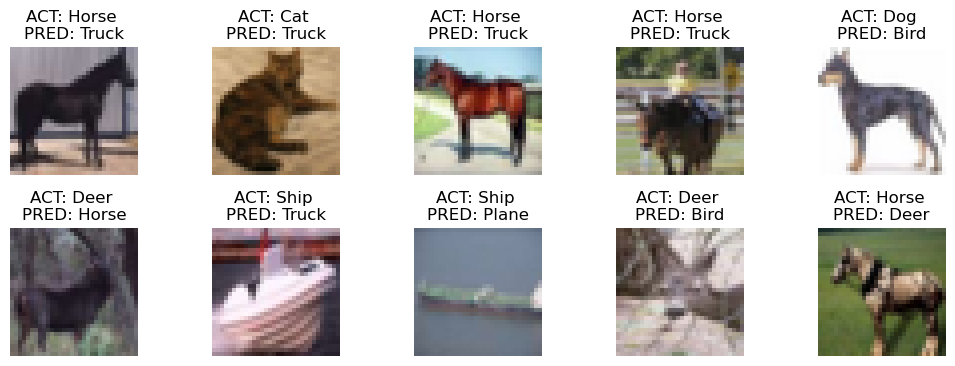

In [19]:
# Plot misclassified images
fig, axs = plot_misclassified_images(
    data=misclassified_image_data, class_label=classes, num_images=10
)
plt.show()
# plt.savefig("Misclassified Images.png")

## GradCAM (Misclassified)


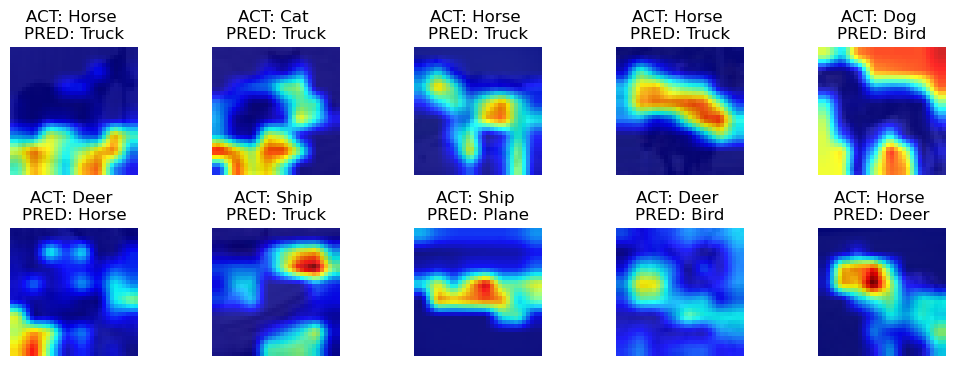

In [22]:
# Plot misclassified images
fig, axs = plot_gradcam_images(
    model=model,
    data=misclassified_image_data,
    class_label=classes,
    # Use penultimate block of resnet18 layer 3 as the target layer for gradcam
    target_layers=[model.layer3[-1]],
    device=device_support,
    targets=None,
    num_images=10,
    image_weight=0.15,
)
plt.show()
# plt.savefig("GradCAM Images.png")